# Use-case for LIME explanations


## Loading the pre-trained model and its initialization

We will use the HYPERVIEW VisonTransformer model, sourced from [the huggingface repository](https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer). 

This model has won the [HYPERVIEW Challenge](https://ai4eo.eu/challenge/hyperview-challenge/) organized by The European Space Agency. It is based on the original code from the [hyperview_eagleeyes repository](https://github.com/ridvansalihkuzu/hyperview_eagleeyes/tree/master/experimental_1)

In [60]:
import clip
import torch  # Make sure to import torch

from clip.downstream_task import TaskType


device = "cpu"  # Change to 'cuda' if you have a GPU
num_classes = 4  # Number of classes in the original HYPERVIEW dataset

# Load the CLIP model with the downstream task configuration
model, _ = clip.load("ViT-L/14", device, downstream_task=TaskType.HYPERVIEW, class_num=num_classes)

# Load the pre-trained weights
model.load_state_dict(torch.load("VisionTransformer.pt", map_location=device))
model.eval()  # Set the model to evaluation mode

INFO: Download Target: C:\Users\tymot/.cache/clip\ViT-L-14.pt


C:\Users\tymot\AppData\Local\Temp\ipykernel_14948\743838718.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("VisionTransformer.pt", map

CLIP(
  (external_dim_reduction): HyperDimensionReduction(
    (dim1): Conv2d(150, 64, kernel_size=(1, 1), stride=(1, 1))
    (act1): Hardswish()
    (dim2): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    (act2): Hardswish()
  )
  (external_image_mlp_header): HyperHead(
    (hidden1): Linear(in_features=768, out_features=768, bias=True)
    (act1): Hardswish()
    (hidden2): Linear(in_features=768, out_features=384, bias=True)
    (act2): Hardswish()
    (hidden3): Linear(in_features=384, out_features=4, bias=True)
    (act3): Hardsigmoid()
  )
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
         

## Load the sample images

In [61]:
import numpy as np
from albumentations.pytorch import ToTensorV2
import albumentations as A


def _shape_pad(data):
    max_edge = np.max(data.shape[1:])
    shape = (max_edge, max_edge)
    padded = np.pad(data, ((0, 0), (0, (shape[0] - data.shape[1])), (0, (shape[1] - data.shape[2]))), "wrap")
    # print(padded.shape)
    return padded


def load_single_npz_image(image_path):
    with np.load(image_path) as npz:
        data = npz["data"]
        mask = npz["mask"]

        mask = 1 - mask.astype(int)

        mask = _shape_pad(mask)
        data = _shape_pad(data)

        mask = mask.transpose((1, 2, 0))
        data = data.transpose((1, 2, 0))
        data = data / 5419

        return data, mask


def get_eval_transform(image_shape):
    return A.Compose(
        [
            A.Resize(image_shape, image_shape),
            # A.Normalize(mean=eval_stats[0]*eval_stats[2], std=eval_stats[1]*eval_stats[2], max_pixel_value=1)
            ToTensorV2(),
        ]
    )

In [137]:
data, mask = load_single_npz_image("sample_data/2.npz")
data = data * mask
data = data.astype(np.float32)
eval_tr = get_eval_transform(224)

image_np = eval_tr(image=data)["image"]

In [138]:
wavelengths = [
    462.08,
    465.27,
    468.47,
    471.67,
    474.86,
    478.06,
    481.26,
    484.45,
    487.65,
    490.85,
    494.04,
    497.24,
    500.43,
    503.63,
    506.83,
    510.03,
    513.22,
    516.42,
    519.61,
    522.81,
    526.01,
    529.2,
    532.4,
    535.6,
    538.79,
    541.99,
    545.19,
    548.38,
    551.58,
    554.78,
    557.97,
    561.17,
    564.37,
    567.56,
    570.76,
    573.96,
    577.15,
    580.35,
    583.55,
    586.74,
    589.94,
    593.14,
    596.33,
    599.53,
    602.73,
    605.92,
    609.12,
    612.32,
    615.51,
    618.71,
    621.91,
    625.1,
    628.3,
    631.5,
    634.69,
    637.89,
    641.09,
    644.28,
    647.48,
    650.67,
    653.87,
    657.07,
    660.27,
    663.46,
    666.66,
    669.85,
    673.05,
    676.25,
    679.45,
    682.64,
    685.84,
    689.03,
    692.23,
    695.43,
    698.62,
    701.82,
    705.02,
    708.21,
    711.41,
    714.61,
    717.8,
    721.0,
    724.2,
    727.39,
    730.59,
    733.79,
    736.98,
    740.18,
    743.38,
    746.57,
    749.77,
    752.97,
    756.16,
    759.36,
    762.56,
    765.75,
    768.95,
    772.15,
    775.34,
    778.54,
    781.74,
    784.93,
    788.13,
    791.33,
    794.52,
    797.72,
    800.92,
    804.11,
    807.31,
    810.51,
    813.7,
    816.9,
    820.1,
    823.29,
    826.49,
    829.68,
    832.88,
    836.08,
    839.28,
    842.47,
    845.67,
    848.86,
    852.06,
    855.26,
    858.46,
    861.65,
    864.85,
    868.04,
    871.24,
    874.44,
    877.63,
    880.83,
    884.03,
    887.22,
    890.42,
    893.62,
    896.81,
    900.01,
    903.21,
    906.4,
    909.6,
    912.8,
    915.99,
    919.19,
    922.39,
    925.58,
    928.78,
    931.98,
    935.17,
    938.37,
]

## Load the package and preview the images

In [139]:
image_np.shape

torch.Size([150, 224, 224])

In [140]:
import meteors as mt

image_0 = mt.Image(image=image_np, wavelengths=wavelengths, orientation="CWH")

2024-09-09 18:07:13.720 | DEBUG    | meteors.image:resolve_inference_device:108 - Device for inference: cpu


<Axes: >

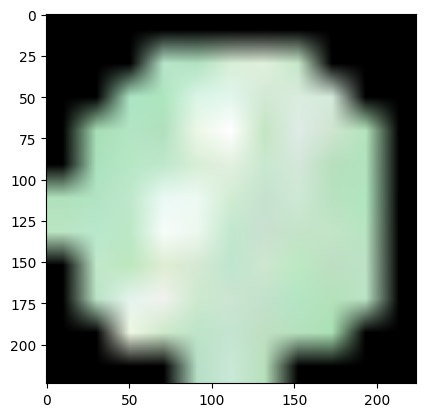

In [141]:
import matplotlib.pyplot as plt

mt.visualize.lime_visualize.visualize_image(image_0, None)

In [142]:
image_0.image.shape

torch.Size([150, 224, 224])

In [143]:
model(image_0.image.unsqueeze(0), device)  # example model predictions

tensor([[0.2073, 0.3471, 0.3853, 0.8820]], grad_fn=<HardsigmoidBackward0>)

## Initialize the LIME object

In [144]:
explainable_model = mt.utils.models.ExplainableModel(model, "regression")

interpretable_model = mt.utils.models.SkLearnLasso(alpha=20)

lime = mt.Lime(explainable_model, interpretable_model)

Text(0.5, 0.98, 'Patch segmentation and the image')

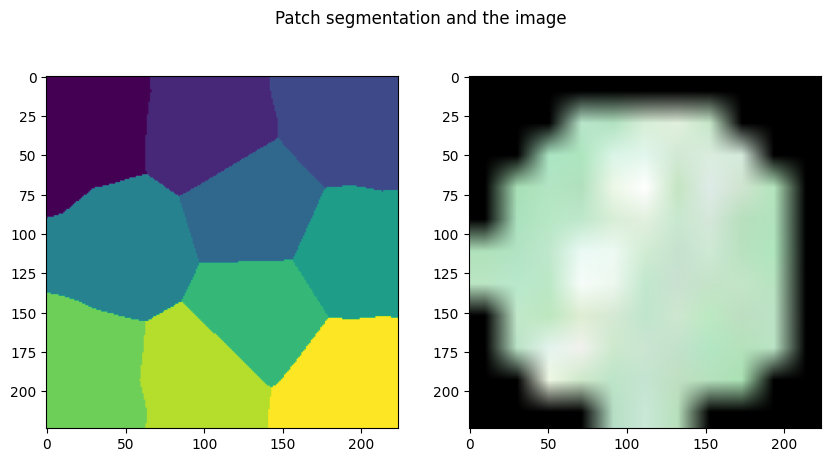

In [145]:
segmentation_mask = lime.get_segmentation_mask(image_0)  # produce a slic segmentation mask


fig = plt.figure(figsize=(10, 5))
# subplots
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(segmentation_mask[0, ...])

ax2.imshow(image_0.get_rgb_image(apply_mask=False, output_channel_axis=2))

plt.suptitle("Patch segmentation and the image")

In [148]:
spatial_attributes = lime.get_spatial_attributes(image_0, segmentation_mask, target=1)

Lime attribution:   0%|          | 0/3 [00:00<?, ?it/s]

2024-09-09 18:07:50.177 | DEBUG    | meteors.image:resolve_inference_device:108 - Device for inference: cpu


In [149]:
spatial_attributes.attributes.abs().sum()

tensor(0.)

AssertionError: Cannot normalize by scale factor = 0

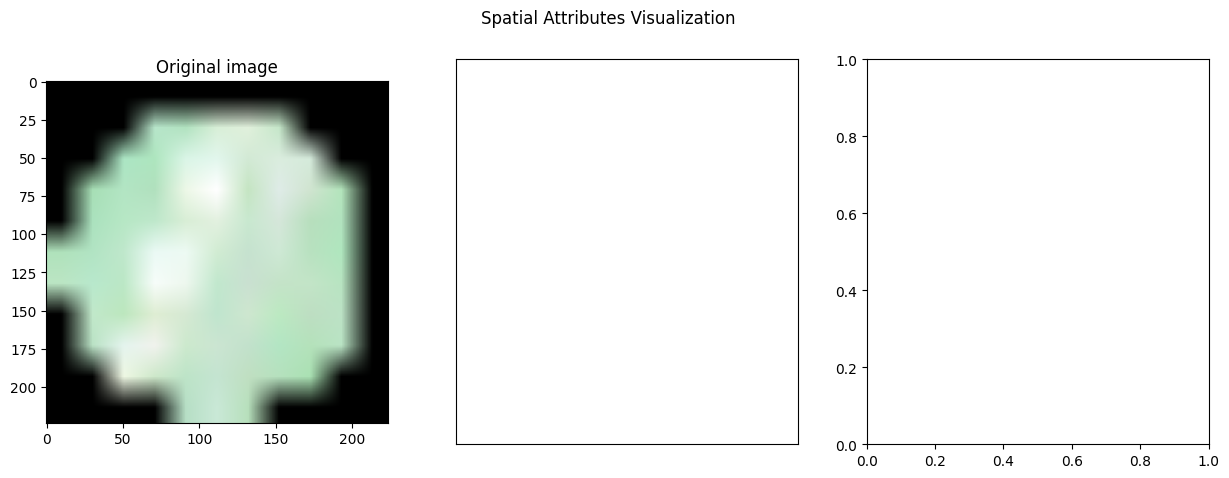

In [150]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)

In [156]:
band_mask, band_names = mt.Lime.get_band_mask(image_0, ["R", "G", "B"])

2024-09-09 18:10:04.645 | DEBUG    | meteors.lime:get_band_mask:952 - Getting band mask from band names of spectral bands
2024-09-09 18:10:04.646 | DEBUG    | meteors.lime:_get_band_wavelengths_indices_from_band_names:1100 - band_names is a list of segments, creating a dictionary of segments
2024-09-09 18:10:04.647 | DEBUG    | meteors.lime:_create_tensor_band_mask:1435 - Creating a band mask on the device cpu using 3 segments
2024-09-09 18:10:04.650 | WARNING  | meteors.lime:_check_overlapping_segments:1283 - Segments G and B are overlapping on wavelength 510.0299987792969
2024-09-09 18:10:04.651 | WARNING  | meteors.lime:_check_overlapping_segments:1283 - Segments G and B are overlapping on wavelength 513.219970703125
2024-09-09 18:10:04.651 | WARNING  | meteors.lime:_check_overlapping_segments:1283 - Segments G and B are overlapping on wavelength 516.4199829101562
2024-09-09 18:10:04.652 | WARNING  | meteors.lime:_check_overlapping_segments:1283 - Segments G and B are overlapping on

In [157]:
band_mask.shape

torch.Size([150, 1, 1])

In [158]:
band_names

{'R': 1, 'G': 2, 'B': 3}

In [160]:
spectral_attributes = lime.get_spectral_attributes(image_0, band_mask=band_mask, target=1, band_names=band_names)

2024-09-09 18:10:31.400 | DEBUG    | meteors.lime:get_spectral_attributes:1626 - Band names are provided, using them. In future it there should be an option to validate them
2024-09-09 18:10:37.482 | DEBUG    | meteors.image:resolve_inference_device:108 - Device for inference: cpu


In [165]:
spectral_attributes.attributes.dtype

torch.float32

RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Int

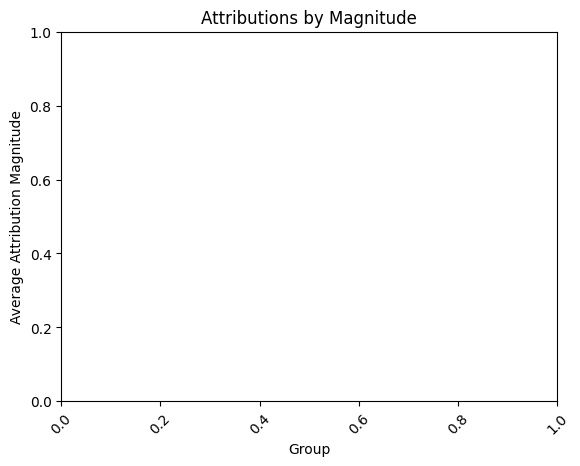

In [164]:
mt.visualize.visualize_spectral_attributes_by_magnitude(spectral_attributes, None)